In [13]:
import torch
import torch.nn as nn
import numpy as np
from unet import UNet
import matplotlib.pyplot as plt
import torchvision.ops as ops
import cv2 as cv
import os

In [14]:
torch.cuda.set_device(0)
device = torch.device('cuda')
loss_function = nn.BCEWithLogitsLoss()

In [15]:
images = []
directory = "train\\"
for folder in os.listdir(directory):
    inner_directory = os.path.join(directory, folder)
    for file in os.listdir(inner_directory):
        img = cv.imread(os.path.join(inner_directory, file))
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (224, 224))
        images.append(img)
        images.append(cv.rotate(img, cv.ROTATE_90_CLOCKWISE))
        images.append(cv.rotate(img, cv.ROTATE_90_COUNTERCLOCKWISE))
        images.append(cv.rotate(img, cv.ROTATE_180))
images = np.stack(images)/255

r = images[:, :, :, 0]
g = images[:, :, :, 1]
b = images[:, :, :, 2]

r = (r - 0.485)/(0.229)
g = (g - 0.456)/(0.224)
b = (b - 0.406)/(0.225)

images = np.stack([r, g, b], axis=3)
np.save("images.npy", images)

In [16]:
masks = []
directory = "masks\\"
for folder in os.listdir(directory):
    inner_directory = os.path.join(directory, folder)
    for file in os.listdir(inner_directory):
        img = np.load(os.path.join(inner_directory, file))
        masks.append(np.rot90(img, 0))
        masks.append(np.rot90(img, 1, axes=(1, 0)))
        masks.append(np.rot90(img, 1, axes=(0, 1)))
        masks.append(np.rot90(img, 2))
masks = np.stack(masks)

print(masks.shape)

np.save("masks.npy", masks)

(1348, 224, 224)


In [ ]:
images = torch.tensor(np.load("images.npy"), dtype=torch.float32)
masks = torch.tensor(np.load("masks.npy"), dtype=torch.float32)

# 80:20 split when validating
# split = int(images.shape[0]*0.8)

# 100:0 split when training model to submit
split = int(images.shape[0]*1)
train_images = images[:split]
train_masks = masks[:split]

val_images = images[split:]
val_masks = masks[split:]

print(train_masks.shape)
print(val_masks.shape)

torch.Size([1348, 224, 224])
torch.Size([0, 224, 224])


In [18]:
model = UNet(num_classes=1, in_channels=3, depth=5, merge_mode='concat')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.to(device);

In [19]:
def val_loss():
	val_losses = []
	for i in range(val_images.shape[0]):
		val_losses.append(loss_function(model(val_images[i:i+1].permute(0, 3, 1, 2).to(device)).squeeze(), val_masks[i:i+1].to(device).squeeze()).item())
	return (sum(val_losses)/len(val_losses))

In [20]:
losses = []
val_losses = []

In [21]:
n_epochs = 100
batch_size = 16

for epoch in range(n_epochs):
	permutation = torch.randperm(train_images.shape[0])
	for i in range(0, permutation.shape[0], batch_size):
		optimizer.zero_grad()

		indices = permutation[i:i+batch_size]
		x, y = train_images[indices], train_masks[indices]

		x = x.to(device)
		y = y.to(device)

		logits = model(x.permute(0, 3, 1, 2))
		loss = loss_function(logits.squeeze(), y.squeeze())
		losses.append(loss.item())
		
		loss.backward()
		optimizer.step()
	# val_losses.append(val_loss())

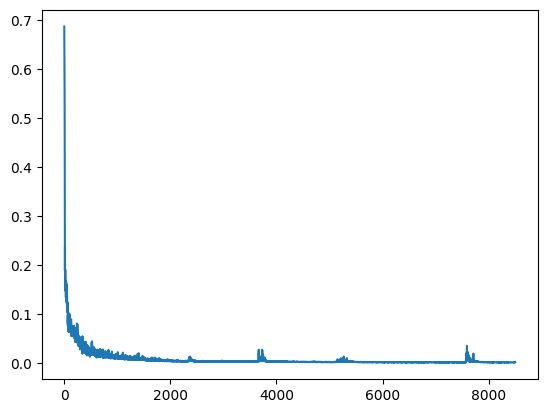

In [22]:
plt.plot(losses)

In [23]:
torch.save(model.state_dict(), "models/unet.pt")